# Load data

In [18]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

from iterativennsimple.Sequential2D import Sequential2D, Identity

import json

In [19]:
# Turn a pandas dataframe into a pytorch tensor
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [20]:
#name = 'regression_line'
#name = 'pca_line'
#name = 'circle'
#name = 'regression_circle'
name = 'MNIST'

# Read the start data
z_start = pd.read_parquet(f'../data/processed/{name}_start.parquet')
# Read the target data
z_target = pd.read_parquet(f'../data/processed/{name}_target.parquet')

## Data preprocessing

In [21]:
z_start_tensor = df_to_tensor(z_start)
z_target_tensor = df_to_tensor(z_target)

# compute a mask for the data where every entry in each column is the same
# this is used to remove columns that are constant
mask = (z_start_tensor == z_target_tensor).all(axis=0)
mask.shape

x_all = z_start_tensor[:, mask]
y_all = z_target_tensor[:, ~mask]

X.shape, Y.shape

(torch.Size([10000, 784]), torch.Size([10000, 1]))

# MLP model

In [33]:
input_size = x_all.shape[1]
h1_size = 10
h2_size = 5
output_size = y_all.shape[1]

I = Identity(in_features=input_size, out_features=input_size)
f1 = torch.nn.Linear(in_features=input_size, out_features=h1_size)
f2 = torch.nn.Linear(in_features=h1_size,    out_features=h2_size)
f3 = torch.nn.Linear(in_features=h2_size,    out_features=output_size)    

in_features_list  = [input_size, h1_size, h2_size, output_size]
out_features_list = [input_size, h1_size, h2_size, output_size]
blocks = [[I,    None, None, None],
          [f1,   None, None, None],
          [None, f2,   None, None],
          [None, None, f3,   None]]

def transpose_blocks(blocks):
    return [[blocks[j][i] for j in range(len(blocks))] for i in range(len(blocks[0]))]

map = Sequential2D(
    in_features_list=in_features_list,
    out_features_list=out_features_list,
    blocks=transpose_blocks(blocks)
)   

In [34]:
# a dataloader which returns a batch of start and target data
class Data(torch.utils.data.Dataset):
    def __init__(self, z_start, z_target):
        self.z_start = z_start
        self.z_target = z_target
    def __len__(self):
        return len(self.z_start)
    def __getitem__(self, idx):
        return self.z_start[idx], self.z_target[idx]
    
train_data = Data(z_start_tensor, z_target_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)

In [35]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(map.parameters(), lr=0.001)

In [18]:
max_epochs = 500
# Train the model
for epoch in range(max_epochs):
    for batch_idx, (start, target) in enumerate(train_loader):
        optimizer.zero_grad()

        # STOPPED HERE
        mapped = start


        loss = 0.0
        for i in range(iterations):
            mapped = map(mapped)
            loss += criterion(mapped, target)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}')

Epoch 0, Batch 9, Loss 5.545944690704346
Epoch 100, Batch 9, Loss 0.02409006655216217
Epoch 200, Batch 9, Loss 0.015681838616728783
Epoch 300, Batch 9, Loss 0.01260304730385542
Epoch 400, Batch 9, Loss 0.01139049232006073


# Training data

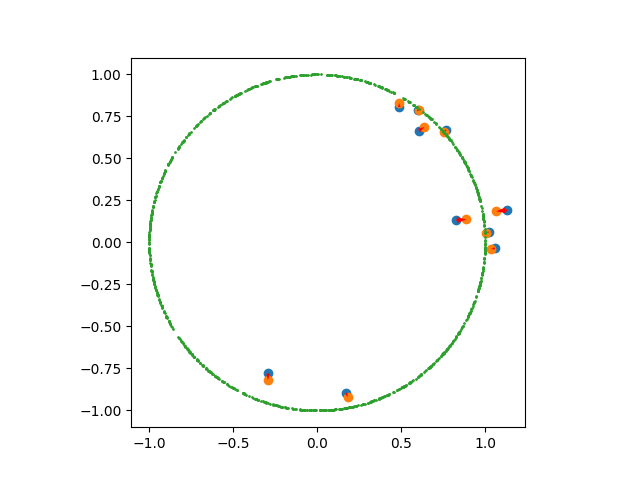

In [19]:
plot_iterations = 1
mapped_tensor = z_start_tensor
for i in range(plot_iterations):
    mapped_tensor = map(mapped_tensor)
mapped_tensor = mapped_tensor.detach()

plot_points = 10

plt.figure()

plt.scatter(z_start_tensor[:plot_points,0], z_start_tensor[:plot_points,1])
plt.scatter(mapped_tensor[:plot_points,0], mapped_tensor[:plot_points,1])
dx = mapped_tensor[:plot_points,0]-z_start_tensor[:plot_points,0]
dy = mapped_tensor[:plot_points,1]-z_start_tensor[:plot_points,1]
plt.quiver(z_start_tensor[:plot_points,0], z_start_tensor[:plot_points,1], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.scatter(z_target_tensor[:,0], z_target_tensor[:,1], s=1)
plt.gca().set_aspect('equal')
plt.show()

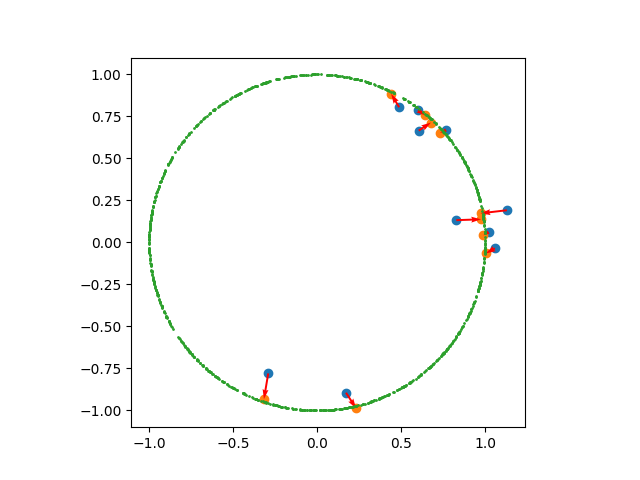

In [20]:
plot_iterations = iterations
mapped_tensor = z_start_tensor
for i in range(plot_iterations):
    mapped_tensor = map(mapped_tensor)
mapped_tensor = mapped_tensor.detach()

plot_points = 10

plt.figure()

plt.scatter(z_start_tensor[:plot_points,0], z_start_tensor[:plot_points,1])
plt.scatter(mapped_tensor[:plot_points,0], mapped_tensor[:plot_points,1])
dx = mapped_tensor[:plot_points,0]-z_start_tensor[:plot_points,0]
dy = mapped_tensor[:plot_points,1]-z_start_tensor[:plot_points,1]
plt.quiver(z_start_tensor[:plot_points,0], z_start_tensor[:plot_points,1], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.scatter(z_target_tensor[:,0], z_target_tensor[:,1], s=1)
plt.gca().set_aspect('equal')
plt.show()

# Path

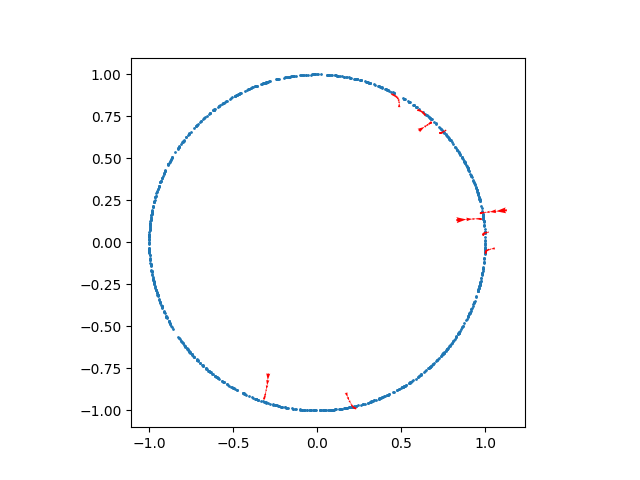

In [21]:
mapped_tensors = [z_start_tensor]
for i in range(iterations):
    mapped_tensors.append(map(mapped_tensors[i]).detach())

plot_points = 10

plt.figure()

plt.scatter(z_target_tensor[:,0], z_target_tensor[:,1], s=1)
for i, mapped_tensor in enumerate(mapped_tensors):
    if i > 0:
        start = mapped_tensors[i-1]
        target = mapped_tensors[i]
        dx = target[:plot_points,0]-start[:plot_points,0]
        dy = target[:plot_points,1]-start[:plot_points,1]
        plt.quiver(start[:plot_points,0], start[:plot_points,1], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.gca().set_aspect('equal')
plt.show()

# Testing data

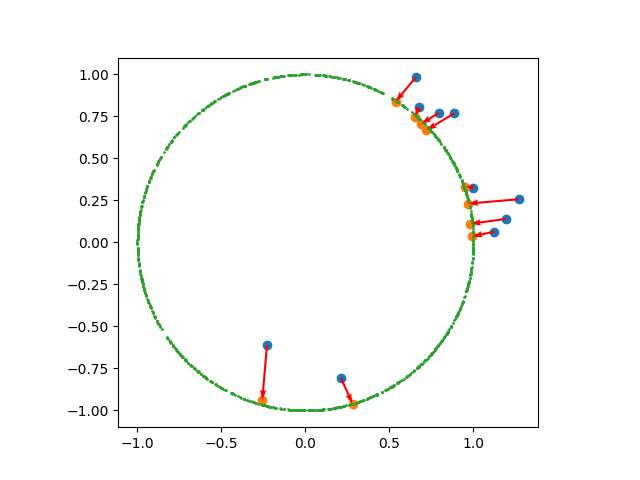

In [22]:
z_start_tensor_test = z_start_tensor+torch.rand_like(z_start_tensor)*0.2
mapped_tensor = z_start_tensor_test
for i in range(iterations):
    mapped_tensor = map(mapped_tensor)
mapped_tensor = mapped_tensor.detach()

plot_points = 10

plt.figure()

plt.scatter(z_start_tensor_test[:plot_points,0], 
            z_start_tensor_test[:plot_points,1])
plt.scatter(mapped_tensor[:plot_points,0], mapped_tensor[:plot_points,1])
dx = mapped_tensor[:plot_points,0]-z_start_tensor_test[:plot_points,0]
dy = mapped_tensor[:plot_points,1]-z_start_tensor_test[:plot_points,1]
plt.quiver(z_start_tensor_test[:plot_points,0], 
           z_start_tensor_test[:plot_points,1], 
           dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.scatter(z_target_tensor[:,0], z_target_tensor[:,1], s=1)
plt.gca().set_aspect('equal')
plt.show()